### How to pull Maxar VHR Stereo Pairs
This script uses the Maxar MGP API to pull the footprints, image ID, and stereo pair ID for Maxar VHR Stereo Pairs
https://github.com/Maxar-Corp/maxar-geospatial-platform
https://developers.maxar.com/docs/discovery/guides/MaxarCatalogSearchTutorial#querying-stereo-pairs

It should be noted that pulling the actual stereo images itself is another process and has a cost attcahed. This is more of a demonstration of how to find relevant, high-quality optical imagery for a given area

In [ ]:
#%pip install mgp_sdk

In [ ]:
# This API requires a local config file ~/.MGP-config in your home directory that looks like this:
#[mgp]
#user_name=EMAIL
#user_password=PASSWORD
#client_id=mgp

In [1]:
import geopandas as gpd
from shapely.geometry import shape
import os
from MGP_SDK.interface import Interface
import numpy as np
import os
from datetime import timedelta
from shapely.geometry import box
from datetime import datetime as dt
import time
import pandas as pd
from shapely.geometry import mapping
from pyproj import CRS

In [2]:
# define your MGP auth and specify datasets of interest
interface = Interface()
print(f"interface.discovery_service.server_checks.version {interface.discovery_service.server_checks.version}")
print(f"interface.discovery_service.server_checks.api_version {interface.discovery_service.server_checks.api_version}")
auth_token = interface.auth.access
# define VHR Maxar mono datasets
nextview = ['wv01', 'wv02', 'wv03-vnir', 'ge01']
nextview_str = ','.join(nextview)

interface.discovery_service.server_checks.version Python1.3.1
interface.discovery_service.server_checks.api_version v1


In [3]:
# Let's select a bounding box to search for imagery, mt. Rainier arbitrarily
bbox = '-121.87942226465918, 46.778576961651986, -121.6396941248582, 46.95409358582829'

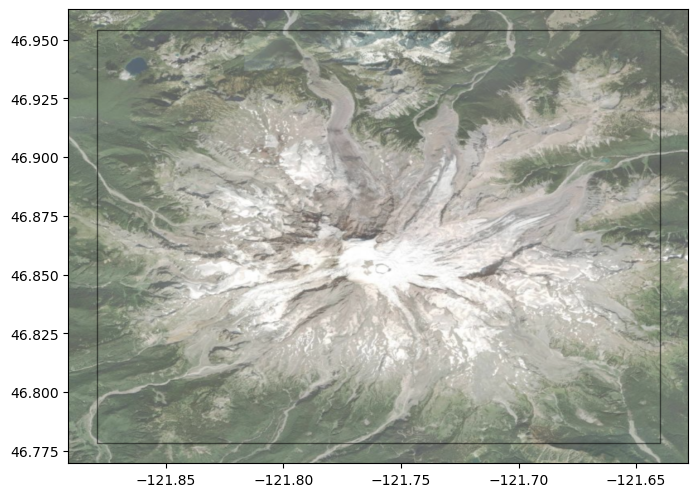

In [10]:
# Here's the bbox over a basemap
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(figsize=(8, 6))
shapely_bbox = box(-121.87942226465918, 46.778576961651986, -121.6396941248582, 46.95409358582829)
gpd.GeoSeries(shapely_bbox).plot(ax=ax, facecolor='none', alpha=0.5)
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Esri.WorldImagery, alpha=0.7, attribution=False)

In [22]:
# Now let's search for some stereo pairs
"""
collections = datasets of interest, need to be comma separated as seen in variable nextview_str
bbox = bbox to search for images in, format: minx,miny,maxx,maxy as seen from 'bbox' variable above
cloud_cover = maximum percentage of cloudcover in images
datetime = start and end date for search, format %Y-%m-%dT%H:%M:%SZ/%Y-%m-%dT%H:%M:%SZ
limit = maximum number of results to return
"""
cloud_cover = 20
# search for 2023 arbitrarily
start = '2023-01-01T00:00:00Z'
end = '2023-12-31T23:59:59Z'
stac = interface.discovery_service.stac_search(
        collections=nextview_str,
        bbox=bbox,
        where=f"eo:cloud_cover < {cloud_cover}",
        datetime=f"{start}/{end}",
        sortby='datetime',
        limit=1000)

In [25]:
gdf = gpd.GeoDataFrame.from_features(stac, crs=4326)

In [27]:
gdf

,geometry,gsd,title,datetime,eo:bands,platform,instruments,associations,view:azimuth,constellation,...,target_to_spacecraft_azimuth_end,target_to_spacecraft_azimuth_max,target_to_spacecraft_azimuth_min,spacecraft_to_target_azimuth_start,target_to_spacecraft_azimuth_start,target_to_spacecraft_elevation_avg,target_to_spacecraft_elevation_end,target_to_spacecraft_elevation_max,target_to_spacecraft_elevation_min,target_to_spacecraft_elevation_start
0,"POLYGON ((-121.61721 46.89255, -121.61643 46.9...",0.771637,Maxar WV02 Image 10303F0015DAF700,2023-10-06T19:06:56.309006Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",worldview-02,[VNIR],[],203.416375,maxar,...,20.568760,21.193636,20.568760,203.784450,21.193636,44.643510,44.371333,44.976793,44.371333,44.976793
1,"POLYGON ((-121.82486 47.01027, -121.82453 46.9...",0.606152,Maxar WV01 Image 10200100DC9F9200,2023-08-18T22:08:10.390169Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],9.083821,maxar,...,192.067032,192.067032,186.962728,6.693390,186.962728,61.321927,64.178628,64.178628,58.289955,58.289955
2,"POLYGON ((-121.81122 47.01016, -121.81189 46.9...",0.531037,Maxar WV01 Image 10200100DB8DF500,2023-08-18T22:07:16.640094Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],201.051571,maxar,...,14.930269,29.455616,14.930269,209.575240,29.455616,74.218103,71.881788,76.858123,71.881788,76.858123
3,"POLYGON ((-121.63714 46.86709, -121.63692 46.8...",0.586413,Maxar WV02 Image 10303F0010DAF600,2023-08-18T19:03:48.045810Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",worldview-02,[VNIR],[],218.739220,maxar,...,35.903651,36.918471,35.903651,219.338710,36.918471,58.035688,57.875390,58.240510,57.875390,58.240510
4,"POLYGON ((-121.78048 45.98087, -121.78007 46.0...",0.567546,Maxar WV01 Image 10200100DA72C700,2023-06-28T22:09:01.402106Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],11.086272,maxar,...,188.857748,196.353000,188.857748,16.347143,196.353000,67.052535,58.713561,77.609335,58.713561,77.609335
5,"POLYGON ((-121.65740 46.95969, -121.65750 47.0...",0.474062,Maxar GE01 Image 105001003485E800,2023-06-23T18:59:54.885249Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",geoeye-01,[VNIR],[],248.136635,maxar,...,96.388458,96.388458,44.376999,224.377000,44.376999,65.563844,70.427753,70.427753,57.465411,57.465411
6,"POLYGON ((-121.89575 46.93773, -121.89580 46.9...",0.586300,Maxar WV02 Image 10300100E1091400,2023-03-01T19:33:37.277967Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",worldview-02,[VNIR],[],65.204900,maxar,...,249.175890,249.175890,247.761846,64.454640,247.761846,57.968922,57.942514,57.986552,57.942514,57.986552


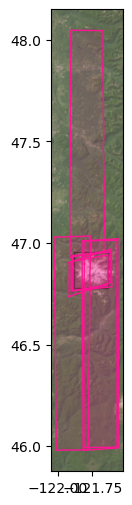

In [30]:
# seems like there are 7 mono VHR images for our bbox of Rainier in 2023 with a cloud cover % <20
# let's plot them
fig, ax = plt.subplots(figsize=(8, 6))
shapely_bbox = box(-121.87942226465918, 46.778576961651986, -121.6396941248582, 46.95409358582829)
gpd.GeoSeries(shapely_bbox).plot(ax=ax, facecolor='none', alpha=0.5)
# gdf is in crs 4326
gdf.plot(ax=ax, facecolor=(1, 20/255, 147/255, 0.1), edgecolor=(1, 20/255, 147/255, 1))
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Esri.WorldImagery, alpha=0.7, attribution=False)

In [91]:
# now let's get the stereo pairs for these mono images
gdf_stereo = gdf[gdf['stereo_pair_identifiers'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
gdf_stereo

,geometry,gsd,title,datetime,eo:bands,platform,instruments,associations,view:azimuth,constellation,...,target_to_spacecraft_azimuth_end,target_to_spacecraft_azimuth_max,target_to_spacecraft_azimuth_min,spacecraft_to_target_azimuth_start,target_to_spacecraft_azimuth_start,target_to_spacecraft_elevation_avg,target_to_spacecraft_elevation_end,target_to_spacecraft_elevation_max,target_to_spacecraft_elevation_min,target_to_spacecraft_elevation_start
0,"POLYGON ((-121.82486 47.01027, -121.82453 46.9...",0.606152,Maxar WV01 Image 10200100DC9F9200,2023-08-18T22:08:10.390169Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],9.083821,maxar,...,192.067032,192.067032,186.962728,6.69339,186.962728,61.321927,64.178628,64.178628,58.289955,58.289955
1,"POLYGON ((-121.81122 47.01016, -121.81189 46.9...",0.531037,Maxar WV01 Image 10200100DB8DF500,2023-08-18T22:07:16.640094Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],201.051571,maxar,...,14.930269,29.455616,14.930269,209.57524,29.455616,74.218103,71.881788,76.858123,71.881788,76.858123
2,"POLYGON ((-121.89575 46.93773, -121.89580 46.9...",0.586300,Maxar WV02 Image 10300100E1091400,2023-03-01T19:33:37.277967Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",worldview-02,[VNIR],[],65.204900,maxar,...,249.175890,249.175890,247.761846,64.45464,247.761846,57.968922,57.942514,57.986552,57.942514,57.986552


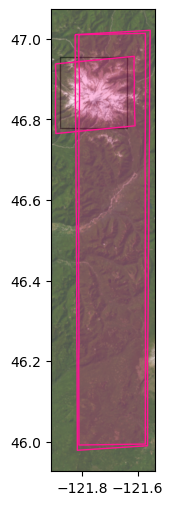

In [32]:
# seems like there are 3 stereo pairs
# let's plot them
fig, ax = plt.subplots(figsize=(8, 6))
shapely_bbox = box(-121.87942226465918, 46.778576961651986, -121.6396941248582, 46.95409358582829)
gpd.GeoSeries(shapely_bbox).plot(ax=ax, facecolor='none', alpha=0.5)
# gdf is in crs 4326
gdf_stereo.plot(ax=ax, facecolor=(1, 20/255, 147/255, 0.1), edgecolor=(1, 20/255, 147/255, 1))
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Esri.WorldImagery, alpha=0.7, attribution=False)

In [92]:
# since the stereo IDs are in a list format, let's change them to strings for future processing
gdf_stereo['stereo_pair_identifiers'] = gdf_stereo['stereo_pair_identifiers'].apply(lambda x: x[0])
gdf_stereo.stereo_pair_identifiers

0    e9fde7ab-fd40-4c48-9a4e-159487ff10c5-inv
1    e9fde7ab-fd40-4c48-9a4e-159487ff10c5-inv
2    3f9c4724-6049-47ad-a8be-1aec85e831c7-inv
Name: stereo_pair_identifiers, dtype: object

In [95]:
intersected_rows = []
grouped = gdf_stereo.groupby('stereo_pair_identifiers')
for name, group in grouped:
    print(name, len(group))

3f9c4724-6049-47ad-a8be-1aec85e831c7-inv 1
e9fde7ab-fd40-4c48-9a4e-159487ff10c5-inv 2


In [96]:
# as we can see in the plot above and by manually checking, those tall VHR images on the right have the same
# stereo pair ID. So they're two separate images that overlap where that overlap is the stereo coverage.
# let's intersect those geometries to get a more-accurate spatial coverage of the stereo pair
def get_in_track_stereo(stereo_gdf):
    """
    Function for subsetting mono data to the in-track stereo pairs, otherwise you'll have two rows for each pair.
    Allows us to keep the cloud cover filter as searching the stereo catalogs themselves is more-limited.
    Returns the stereo pair geometry and associated metadata with the mono image that has the greatest off-nadir angle.
    """
    intersected_rows = []
    for name, group in grouped:
        if len(group) > 1:  # Ensure there are at least 2 geometries
            first_stereo = group.geometry.iloc[0]
            intersection = first_stereo
            for second_stereo in group.geometry.iloc[1:]:
                intersection = intersection.intersection(second_stereo)
            # Preserve mono data for the image with the greater off-nadir angle
            max_off_nadir_idx = group['off_nadir_avg'].idxmax()
            in_track_row = group.loc[max_off_nadir_idx].copy()
            in_track_row['geometry'] = intersection
            intersected_rows.append(in_track_row)
        else:
            # if only one geometry, just add it without intersection
            intersected_rows.append(group.iloc[0].copy())
    intersected_gdf = gpd.GeoDataFrame(intersected_rows, geometry='geometry')
    intersected_gdf.crs = stereo_gdf.crs
    return intersected_gdf
# now we process the intersection
gdf_stereo = get_in_track_stereo(gdf_stereo)

In [97]:
gdf_stereo

,geometry,gsd,title,datetime,eo:bands,platform,instruments,associations,view:azimuth,constellation,...,target_to_spacecraft_azimuth_end,target_to_spacecraft_azimuth_max,target_to_spacecraft_azimuth_min,spacecraft_to_target_azimuth_start,target_to_spacecraft_azimuth_start,target_to_spacecraft_elevation_avg,target_to_spacecraft_elevation_end,target_to_spacecraft_elevation_max,target_to_spacecraft_elevation_min,target_to_spacecraft_elevation_start
2,"POLYGON ((-121.89575 46.93773, -121.89580 46.9...",0.586300,Maxar WV02 Image 10300100E1091400,2023-03-01T19:33:37.277967Z,"[{'name': 'pan', 'center_wavelength': 625}, {'...",worldview-02,[VNIR],[],65.204900,maxar,...,249.175890,249.175890,247.761846,64.45464,247.761846,57.968922,57.942514,57.986552,57.942514,57.986552
0,"POLYGON ((-121.57179 47.01352, -121.57113 46.9...",0.606152,Maxar WV01 Image 10200100DC9F9200,2023-08-18T22:08:10.390169Z,"[{'name': 'pan', 'center_wavelength': 650}]",worldview-01,[VNIR],[],9.083821,maxar,...,192.067032,192.067032,186.962728,6.69339,186.962728,61.321927,64.178628,64.178628,58.289955,58.289955


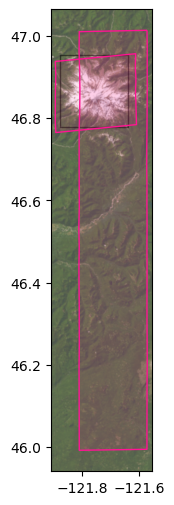

In [98]:
# seems like there are 3 stereo pairs
# let's plot them
fig, ax = plt.subplots(figsize=(8, 6))
shapely_bbox = box(-121.87942226465918, 46.778576961651986, -121.6396941248582, 46.95409358582829)
gpd.GeoSeries(shapely_bbox).plot(ax=ax, facecolor='none', alpha=0.5)
# gdf is in crs 4326
gdf_stereo.plot(ax=ax, facecolor=(1, 20/255, 147/255, 0.1), edgecolor=(1, 20/255, 147/255, 1))
ctx.add_basemap(ax, crs=4326, source=ctx.providers.Esri.WorldImagery, alpha=0.7, attribution=False)

In [100]:
gdf_stereo[['title', 'stereo_pair_identifiers', 'geometry', 'datetime']]

,title,stereo_pair_identifiers,geometry,datetime
2,Maxar WV02 Image 10300100E1091400,3f9c4724-6049-47ad-a8be-1aec85e831c7-inv,"POLYGON ((-121.89575 46.93773, -121.89580 46.9...",2023-03-01T19:33:37.277967Z
0,Maxar WV01 Image 10200100DC9F9200,e9fde7ab-fd40-4c48-9a4e-159487ff10c5-inv,"POLYGON ((-121.57179 47.01352, -121.57113 46.9...",2023-08-18T22:08:10.390169Z


In [ ]:
# Now we have stereo pairs for our bbox of Rainier in 2023 with a cloud cover % <20
# actually getting the imagery data is a whole other process... :)
# hopefully there's a partnership with UW in the near future